In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy import signal, stats, fftpack
from glob import glob
import time

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, find_nearest_ind, get_evoked_firing_rates
from PCIst.PCIst.pci_st import calc_PCIst

In [5]:
%matplotlib notebook

## Functions

In [6]:
# get event triggered firing rates USING find_nearest_ind
# much faster than original
def get_evoked_traces(data, timestamps, events, plot_before, plot_after, data_sample_rate):
    pre_inds = int(plot_before * data_sample_rate)
    post_inds = int(plot_after * data_sample_rate)
    timex = (np.arange(-pre_inds, post_inds) / data_sample_rate)
    
    evoked_traces = np.zeros((len(timex), np.shape(data)[1], len(events)))
    for j, jtime in enumerate(events):
        zeroind = find_nearest_ind(timestamps, jtime)
        data_inds = np.arange(zeroind-pre_inds, zeroind+post_inds)
        evoked_traces[:,:,j] = data[data_inds,:]
    
    return evoked_traces, timex

#### Plot electrodes

## Load experiment instance

In [7]:
start = time.time()

In [8]:
dfolder = r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1'
# load experiment metadata and eeg data
exp = EEGexp(dfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation


In [9]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse'+exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

### Load EEG data and adjusted stimulus log

In [10]:
eeg_data, eeg_ts = exp.load_eegdata()

In [11]:
eeg_chs = np.arange(0, eeg_data.shape[1])

In [12]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good
0,biphasic,70,82.58399,82.58439,0.0004,0,True
1,biphasic,50,86.48837,86.48877,0.0004,0,True
2,biphasic,50,90.16804,90.16844,0.0004,0,True
3,biphasic,50,94.63739,94.63779,0.0004,0,True
4,biphasic,50,98.54527,98.54567,0.0004,0,True


In [13]:
end = time.time()
print('Time to load: {:.2f} s'.format(end-start))

Time to load: 6.58 s


### Stim evoked traces

In the Land, et al. paper (2019) they bandpass filter before pulling the traces. They test multiple bands (all in Hz): 1-50, 5-50, 1-25, 1-100, and 1-300. They seem to favor 1-50 Hz. They see a prominent negative peak (~100 uV) at a latency of ~63 ms, mainly on the electrodes over the visual cortex. The mice are anesthetized with ketamine/xylazine and stimulated with a stroboscope (at 3000 Lumen for 512 us).

In [14]:
plot_before = 0.5 # s, look at 100 ms pre-stim
plot_after = 1.0 # s, look at 500 ms post-stim

low_pass_cutoff = 100
apply_blsub = False

In [15]:
## Loop through all stim events/sweeps and collect traces
traces = {}
avg_traces = {}
filtered_traces = {}
avg_filtered_traces = {}
for st_type in stim_log.stim_type.unique():
    traces[st_type] = {}
    avg_traces[st_type] = {}
    filtered_traces[st_type] = {}
    avg_filtered_traces[st_type] = {}
    
    param_list = np.sort(stim_log[stim_log['stim_type']==st_type].parameter.unique())
    for parami in param_list:
        traces[st_type][parami] = {}
        avg_traces[st_type][parami] = {}
        filtered_traces[st_type][parami] = {}
        avg_filtered_traces[st_type][parami] = {}
        
        sweep_list = np.sort(stim_log[(stim_log['stim_type']==st_type) & (stim_log['parameter']==parami)].sweep.unique())
        for sweepi in sweep_list:
            print('{}, {} \u03BCA, sweep {:d}'.format(st_type, str(parami), sweepi))
            ## Get event times ##
            events = get_stim_events(stim_log, st_type, parami, sweepi)
            if len(events) == 0:
                print('no good trials found')
                continue
            
            ## Get event traces ##
            event_traces, event_ts = get_evoked_traces(
                eeg_data,
                eeg_ts,
                events,
                plot_before,
                plot_after,
                exp.ephys_params['EEG']['sample_rate']
            )
             # design lowpass filter
            filtb, filta = signal.butter(3, 100/(exp.ephys_params['EEG']['sample_rate']/2), btype='low')

            # apply filter
            if apply_blsub:
                blinds = np.squeeze(np.argwhere((event_ts > -0.2) & (event_ts < -0.005)))
                filttraces = signal.filtfilt(filtb, filta, event_traces - np.mean(event_traces[blinds,:,:], axis=0), axis=0)
            else:
                filttraces = signal.filtfilt(filtb, filta, event_traces, axis=0)
            
            ## Store traces ##
            traces[st_type][parami][sweepi] = [event_ts, event_traces]
            avg_traces[st_type][parami][sweepi] = [event_ts, np.mean(event_traces, axis=2)]
            filtered_traces[st_type][parami][sweepi] = [event_ts, filttraces]
            avg_filtered_traces[st_type][parami][sweepi] = [event_ts, np.mean(filttraces, axis=2)]

biphasic, 50 μA, sweep 0
biphasic, 50 μA, sweep 1
biphasic, 50 μA, sweep 2
biphasic, 50 μA, sweep 3
biphasic, 70 μA, sweep 0
biphasic, 70 μA, sweep 1
biphasic, 70 μA, sweep 2
biphasic, 70 μA, sweep 3
biphasic, 90 μA, sweep 0
biphasic, 90 μA, sweep 1
biphasic, 90 μA, sweep 2
biphasic, 90 μA, sweep 3
fullscreen, white μA, sweep 0
fullscreen, white μA, sweep 1
fullscreen, white μA, sweep 2


### Plotting

Plot one event across all electrodes

<IPython.core.display.Javascript object>


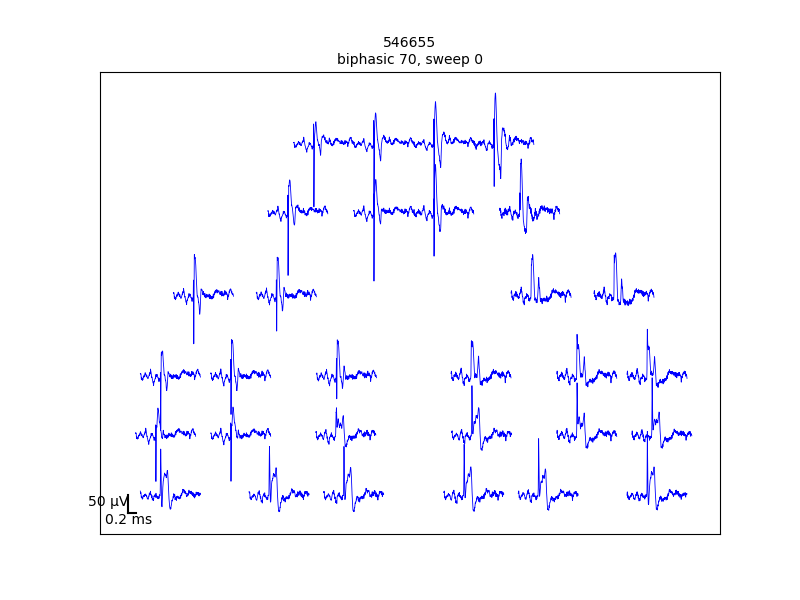

In [60]:
pick_stim = 'biphasic'
pick_param = '70'
pick_sweep = 0
pick_traces = avg_filtered_traces # avg_traces or avg_filtered_traces

xmult = 1.5
ymult = 150

timex = pick_traces[pick_stim][pick_param][pick_sweep][0]
plottraces = pick_traces[pick_stim][pick_param][pick_sweep][1]
fig, ax = plt.subplots(figsize=(8,6))
for chi in range(len(exp.EEG_channel_coordinates)):
    ax.plot(
        timex + (exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        plottraces[:, chi] + (exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        'b',
        linewidth=0.6
    )
#     ax.axvline((0.+(exp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)), ymin=?, ymax=?, color='k', linewidth=0.5)
    if chi == 0:
        mx = timex[0] + exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult * 1.05
        my = exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult

x_len = .2 # x scale bar length in ms
y_len = 50 # y scale bar length in uV
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} ms'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

ax.set_title('{}\n{} {}, sweep {:d}'.format(exp.mouse, pick_stim, str(pick_param), pick_sweep))
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'estim_evoked_map_70_awake.png'), transparent=True)

Plot butterfly for one event

<IPython.core.display.Javascript object>


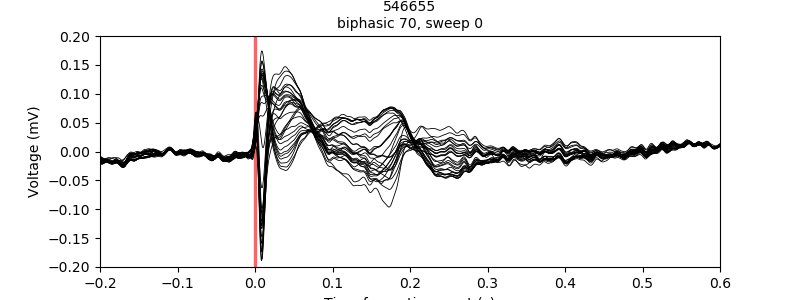

In [68]:
pick_stim = 'biphasic'
pick_param = '70'
pick_sweep = 0
pick_traces = avg_filtered_traces # avg_traces or avg_filtered_traces

prex = .2 # ms before stim to plot
postx = .6 # ms after stim to plot
ylimit = 0.2 # mV

timex = pick_traces[pick_stim][pick_param][pick_sweep][0]
plottraces = pick_traces[pick_stim][pick_param][pick_sweep][1]/1000 # make them into mV
plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(8,3))

ax.plot(timex[plot_inds], plottraces[plot_inds,:], color='k', linewidth=0.6)
ax.axvspan(-.001, .001, color='r', alpha=0.5)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}, sweep {:d}'.format(exp.mouse, pick_stim, str(pick_param), pick_sweep))

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'estim_evoked_BF_70_awake.png'), transparent=True)

## Bipolar reference schemes

### Paired neighbors

In [16]:
neighbor_pairs = [
    [0, 1], [3, 4], [6, 7], [9, 10], [11, 12], [13, 14],
    [2, 27], [5, 24], [8, 21],
    [15, 16], [17, 18], [19, 20], [22, 23], [25, 26], [28, 29]
]

In [17]:
chA_list = []
chB_list = []
ch_AP = []
ch_ML = []
bipolar_eeg_data = np.zeros([eeg_data.shape[0], len(neighbor_pairs)])
for ii, (cha, chb) in enumerate(neighbor_pairs):
    
    ## new coords ##
    chA_list.append(cha)
    chB_list.append(chb)
    ch_AP.append(np.mean([EEGexp.EEG_channel_coordinates['AP'].iloc[cha], EEGexp.EEG_channel_coordinates['AP'].iloc[chb]]))
    ch_ML.append(np.mean([EEGexp.EEG_channel_coordinates['ML'].iloc[cha], EEGexp.EEG_channel_coordinates['ML'].iloc[chb]]))
    
    ## bipolar data ##
    bipolar_eeg_data[:, ii] = eeg_data[:, cha] - eeg_data[:, chb]
    
## dataframe of pairs and locations ##
neighbor_pairs_df = pd.DataFrame({
    'chA': chA_list,
    'chB': chB_list,
    'AP': ch_AP,
    'ML': ch_ML,
})
neighbor_pairs_df.head()

,chA,chB,AP,ML
0,0,1,-4.14,-3.145
1,3,4,-3.04,-3.505
2,6,7,-1.96,-3.465
3,9,10,-0.48,-2.810
4,11,12,1.04,-1.215


In [18]:
## Loop through all stim events/sweeps and collect traces
bp_filtered_traces = {}
avg_bp_filtered_traces = {}
for st_type in stim_log.stim_type.unique():
    bp_filtered_traces[st_type] = {}
    avg_bp_filtered_traces[st_type] = {}
    
    param_list = np.sort(stim_log[stim_log['stim_type']==st_type].parameter.unique())
    for parami in param_list:
        bp_filtered_traces[st_type][parami] = {}
        avg_bp_filtered_traces[st_type][parami] = {}
        
        sweep_list = np.sort(stim_log[(stim_log['stim_type']==st_type) & (stim_log['parameter']==parami)].sweep.unique())
        for sweepi in sweep_list:
            print('{}, {} \u03BCA, sweep {:d}'.format(st_type, str(parami), sweepi))
            ## Get event times ##
            events = get_stim_events(stim_log, st_type, parami, sweepi)
            if len(events) == 0:
                print('no good trials found')
                continue
            
            ## Get event traces ##
            event_traces, event_ts = get_evoked_traces(
                bipolar_eeg_data,
                eeg_ts,
                events,
                plot_before,
                plot_after,
                exp.ephys_params['EEG']['sample_rate']
            )
             # design lowpass filter
            filtb, filta = signal.butter(3, 100/(exp.ephys_params['EEG']['sample_rate']/2), btype='low')

            # apply filter
            if apply_blsub:
                blinds = np.squeeze(np.argwhere((event_ts > -0.2) & (event_ts < -0.005)))
                filttraces = signal.filtfilt(filtb, filta, event_traces - np.mean(event_traces[blinds,:,:], axis=0), axis=0)
            else:
                filttraces = signal.filtfilt(filtb, filta, event_traces, axis=0)
            
            ## Store traces ##
            bp_filtered_traces[st_type][parami][sweepi] = [event_ts, filttraces]
            avg_bp_filtered_traces[st_type][parami][sweepi] = [event_ts, np.mean(filttraces, axis=2)]

biphasic, 50 μA, sweep 0
biphasic, 50 μA, sweep 1
biphasic, 50 μA, sweep 2
biphasic, 50 μA, sweep 3
biphasic, 70 μA, sweep 0
biphasic, 70 μA, sweep 1
biphasic, 70 μA, sweep 2
biphasic, 70 μA, sweep 3
biphasic, 90 μA, sweep 0
biphasic, 90 μA, sweep 1
biphasic, 90 μA, sweep 2
biphasic, 90 μA, sweep 3
fullscreen, white μA, sweep 0
fullscreen, white μA, sweep 1
fullscreen, white μA, sweep 2


### BIPOLAR plotting

<IPython.core.display.Javascript object>


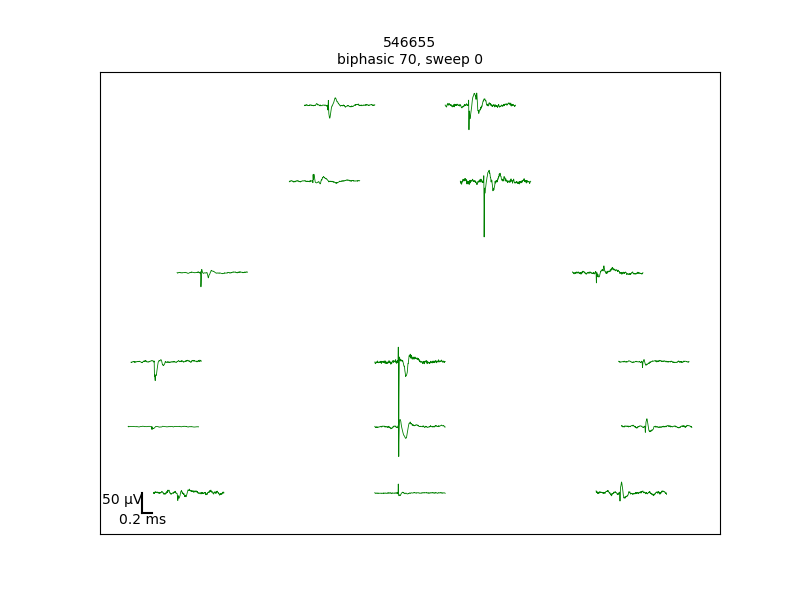

In [61]:
pick_stim = 'biphasic'
pick_param = '70'
pick_sweep = 0
pick_traces = avg_bp_filtered_traces # avg_traces or avg_filtered_traces

xmult = 1.5
ymult = 150

timex = pick_traces[pick_stim][pick_param][pick_sweep][0]
plottraces = pick_traces[pick_stim][pick_param][pick_sweep][1]
fig, ax = plt.subplots(figsize=(8,6))
for chi in range(len(neighbor_pairs_df)):
    ax.plot(
        timex + (neighbor_pairs_df['ML'].iloc[chi] * xmult),
        plottraces[:, chi] + (neighbor_pairs_df['AP'].iloc[chi] * ymult),
        'g',
        linewidth=0.6
    )
#     ax.axvline((0.+(neighbor_pairs_df['ML'].iloc[chi]*xmult)), ymin=?, ymax=?, color='k', linewidth=0.5)
    if chi == 0:
        mx = timex[0] + neighbor_pairs_df['ML'].iloc[chi] * xmult * 1.05
        my = neighbor_pairs_df['AP'].iloc[chi] * ymult

x_len = .2 # x scale bar length in ms
y_len = 50 # y scale bar length in uV
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} ms'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

ax.set_title('{}\n{} {}, sweep {:d}'.format(exp.mouse, pick_stim, str(pick_param), pick_sweep))
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'estim_evoked_map_70_awake_bipolarneighbors.png'), transparent=True)

Plot butterfly for one event

<IPython.core.display.Javascript object>


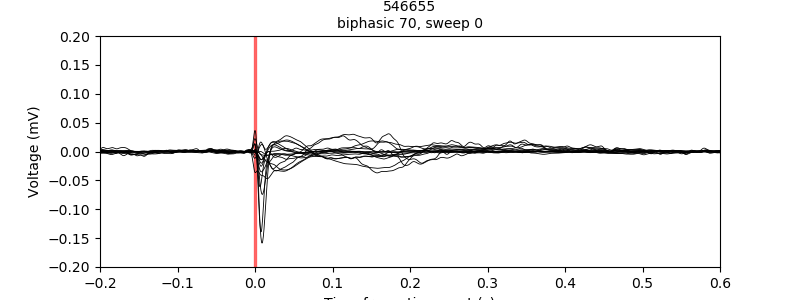

In [69]:
pick_stim = 'biphasic'
pick_param = '70'
pick_sweep = 0
pick_traces = avg_bp_filtered_traces # avg_traces or avg_filtered_traces

prex = .2 # ms before stim to plot
postx = .6 # ms after stim to plot
ylimit = 0.2 # mV

timex = pick_traces[pick_stim][pick_param][pick_sweep][0]
plottraces = pick_traces[pick_stim][pick_param][pick_sweep][1]/1000 # make them into mV
plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(8,3))

ax.plot(timex[plot_inds], plottraces[plot_inds,:], color='k', linewidth=0.6)
ax.axvspan(-.001, .001, color='r', alpha=0.5)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}, sweep {:d}'.format(exp.mouse, pick_stim, str(pick_param), pick_sweep))

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'estim_evoked_BF_70_awake_bipolarneighbors.png'), transparent=True)

### PCI comparison in awake and anest, regular vs. bipolar

In [20]:
states = {'awake': 0, 'anesthetized': 1}

PCI_params = {
    'baseline_window':(-0.5, -0.005), # s before stim for baseline
    'response_window':(0.005, 0.5), # s after stim for response
    'k':1.2,
    'min_snr':1.6, # default 1.1, IR uses 1.6
    'max_var':99,
    'embed':False,
    'n_steps':100,
}

reg_PCI = []
reg_numPCs = []
bp_PCI = []
bp_numPCs = []
for statei, sweepi in states.items():
    # Regular EEG #
    reg_PCI_output = calc_PCIst(
        avg_filtered_traces['biphasic']['70'][sweepi][1].T,
        avg_filtered_traces['biphasic']['70'][sweepi][0],
        full_return=True, **PCI_params
    )
    # Bipolar EEG #
    bp_PCI_output = calc_PCIst(
        avg_bp_filtered_traces['biphasic']['70'][sweepi][1].T,
        avg_bp_filtered_traces['biphasic']['70'][sweepi][0],
        full_return=True, **PCI_params
    )
    # store values #
    reg_PCI.append(reg_PCI_output['PCI'])
    reg_numPCs.append(reg_PCI_output['n_dims'])
    bp_PCI.append(bp_PCI_output['PCI'])
    bp_numPCs.append(bp_PCI_output['n_dims'])

<IPython.core.display.Javascript object>


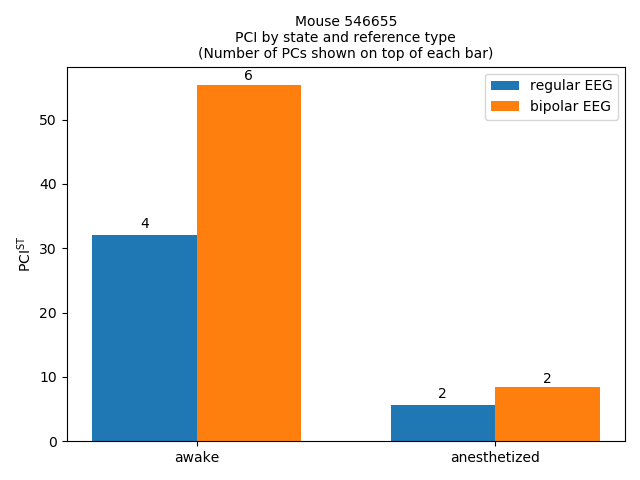

In [22]:
x = np.arange(len(states.keys()))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
regrects = ax.bar(x - width/2, reg_PCI, width, label='regular EEG')
bprects = ax.bar(x + width/2, bp_PCI, width, label='bipolar EEG')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$\mathregular{PCI^{ST}}$')
ax.set_title('Mouse {}\nPCI by state and reference type\n(Number of PCs shown on top of each bar)'.format(exp.mouse))
ax.set_xticks(x)
ax.set_xticklabels(states.keys())
ax.legend()

for i, rect in enumerate(regrects):
    ax.annotate('{}'.format(reg_numPCs[i]),
                xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
for i, rect in enumerate(bprects):
    ax.annotate('{}'.format(bp_numPCs[i]),
                xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

fig.tight_layout()

plt.show()

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'PCIcomparison_EEGvsbipolar.png'), transparent=True)

## Multi subject for PCI comparison

In [52]:
complotsavedir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots'

In [8]:
sub_dirs = {
    '546655': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1',
    '546658': r'C:\Users\lesliec\OneDrive - Allen Institute\data\depth_test\mouse546658\estim_ramp_depth_2020-10-29_13-55-50\experiment1\recording1',
    '547868': r'C:\Users\lesliec\OneDrive - Allen Institute\data\depth_test\mouse547868\estim_ramp_depth_2020-12-03_10-39-59\experiment1\recording1',
    '551398': r'C:\Users\lesliec\OneDrive - Allen Institute\data\depth_test\mouse551398\estim_ramp_depth_2020-12-17_12-18-07\experiment1\recording1',
}

In [9]:
exp_params = {
    '546655': {'param': '70', 'sweep': 0},
    '546658': {'param': 50, 'sweep': 11},
    '547868': {'param': 50, 'sweep': 11},
    '551398': {'param': 50, 'sweep': 11},
}

In [10]:
sub_exp = {}
for mousei, recdiri in sub_dirs.items():
    sub_exp[mousei] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation
Experiment type: electrical stimulation
SomnoSuite log file not found.
Body camera file not found.
Pupil camera file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Body camera file not found.
Pupil camera file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.


#### Bipolar EEG: neighbor pairs

In [11]:
neighbor_pairs = [
    [0, 1], [3, 4], [6, 7], [9, 10], [11, 12], [13, 14],
    [2, 27], [5, 24], [8, 21],
    [15, 16], [17, 18], [19, 20], [22, 23], [25, 26], [28, 29]
]

#### Load EEG data, get bipolar data, get traces.

In [12]:
## parameters ##
before_event = 1. # s, look at 1 s pre-stim
after_event = 1. # s, look at 1 s post-stim
stimtype = 'biphasic' # can be 'fullscreen', 'auditory', or 'biphasic'
apply_blsub = False

PCI_params = {
    'baseline_window':(-0.5, -0.005), # s before stim for baseline
    'response_window':(0.005, 0.5), # s after stim for response
    'k':1.2,
    'min_snr':1.6, # default 1.1, IR uses 1.6
    'max_var':99,
    'embed':False,
    'n_steps':100,
}

In [20]:
## Loop through all subjects, collect traces, calculate PCI
sub_traces = {}
sub_PCI_info = {}
for mousei, expi in sub_exp.items():
    print(expi.mouse)
    # load stim log
    stim_log = pd.read_csv(expi.stimulus_log_file)
    
    # load data
    datai, tsi = expi.load_eegdata()
    eegchs = np.arange(datai.shape[1])
    
    # get bipolar data
    bipolar_datai = np.zeros([datai.shape[0], len(neighbor_pairs)])
    for ii, (cha, chb) in enumerate(neighbor_pairs):
        bipolar_datai[:, ii] = datai[:, cha] - datai[:, chb]
    
    # get evoked traces, and PCI
    sub_traces[mousei] = {}
    sub_PCI_info[mousei] = {}

    ## Get event traces ##
    events = get_stim_events(stim_log, stimtype, exp_params[mousei]['param'], exp_params[mousei]['sweep'])
    # Regular EEG #
    eeg_traces, event_ts = get_evoked_traces(
        datai,
        tsi,
        events,
        before_event,
        after_event,
        expi.ephys_params['EEG']['sample_rate']
    )
    # Bipolar EEG #
    bp_traces, bp_event_ts = get_evoked_traces(
        bipolar_datai,
        tsi,
        events,
        before_event,
        after_event,
        expi.ephys_params['EEG']['sample_rate']
    )
    # design lowpass filter
    filtb, filta = signal.butter(3, 100/(expi.ephys_params['EEG']['sample_rate']/2), btype='low')
    # apply filter
    if apply_blsub:
        blinds = np.squeeze(np.argwhere((event_ts > -0.2) & (event_ts < -0.005)))
        filttraces = signal.filtfilt(filtb, filta, eeg_traces - np.mean(eeg_traces[blinds,:,:], axis=0), axis=0)
        bp_filttraces = signal.filtfilt(filtb, filta, bp_traces - np.mean(bp_traces[blinds,:,:], axis=0), axis=0)
    else:
        filttraces = signal.filtfilt(filtb, filta, eeg_traces, axis=0)
        bp_filttraces = signal.filtfilt(filtb, filta, bp_traces, axis=0)
        

    ## Store traces ##
    sub_traces[mousei]['regular'] = [event_ts, np.mean(filttraces, axis=2)]
    sub_traces[mousei]['bipolar'] = [bp_event_ts, np.mean(bp_filttraces, axis=2)]
    
    ## Calculate PCI on both ##
    # Regular EEG #
    reg_PCI = calc_PCIst(np.mean(filttraces, axis=2).T, event_ts, full_return=True, **PCI_params)
    # Bipolar EEG #
    bp_PCI = calc_PCIst(np.mean(bp_filttraces, axis=2).T, bp_event_ts, full_return=True, **PCI_params)
    # Store PCI info #
    sub_PCI_info[mousei]['regular'] = {'PCI': reg_PCI['PCI'], 'num_PCs': reg_PCI['n_dims']}
    sub_PCI_info[mousei]['bipolar'] = {'PCI': bp_PCI['PCI'], 'num_PCs': bp_PCI['n_dims']}

546655
546658
547868
551398


In [42]:
dfPCI = pd.DataFrame.from_dict(
    {(j,i): sub_PCI_info[i][j] for i in sub_PCI_info.keys() for j in sub_PCI_info[i].keys()},
    orient='index'
)
dfPCI.head()

,,PCI,num_PCs
regular,546655,32.115571,4
bipolar,546655,55.455311,6
regular,546658,15.578181,2
bipolar,546658,44.994990,4
regular,547868,56.394545,5


<IPython.core.display.Javascript object>


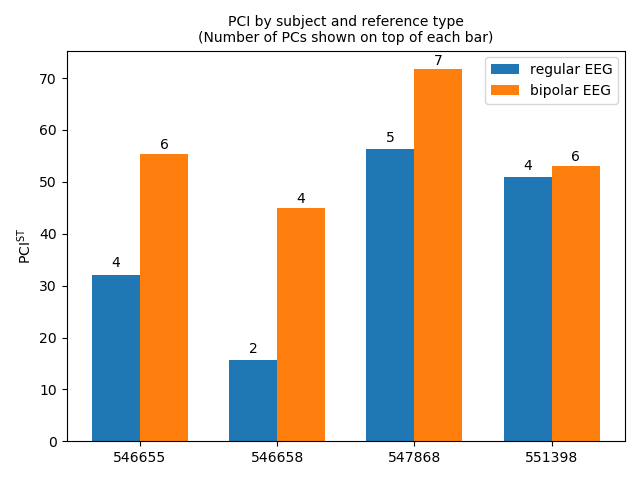

In [53]:
subjects = dfPCI['PCI']['regular'].index
x = np.arange(len(subjects))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
regrects = ax.bar(x - width/2, dfPCI['PCI']['regular'].values, width, label='regular EEG')
bprects = ax.bar(x + width/2, dfPCI['PCI']['bipolar'].values, width, label='bipolar EEG')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$\mathregular{PCI^{ST}}$')
ax.set_title('PCI by subject and reference type\n(Number of PCs shown on top of each bar)')
ax.set_xticks(x)
ax.set_xticklabels(subjects)
ax.legend()

for i, rect in enumerate(regrects):
    ax.annotate('{}'.format(dfPCI['num_PCs']['regular'].values[i]),
                xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
for i, rect in enumerate(bprects):
    ax.annotate('{}'.format(dfPCI['num_PCs']['bipolar'].values[i]),
                xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

fig.tight_layout()

plt.show()

## Save ##
# fig.savefig(os.path.join(complotsavedir, 'PCIcomparison_EEGvsbipolar.png'), transparent=True)

Butterfly plot, lines colored by distance from e-stim electrode